## Notebook para EDA utilizando o dataset _auto-mpg_
> Este dataset é um dos conhecidos entre praticantes de DS/ML por ser simples simples para iniciantes, porém que nos permite entender as limitações de alguns algoritmos. O intuito deste notebook é entender um pouco da estrutura do dataset.
Disponível em: http://archive.ics.uci.edu/ml/datasets/Auto+MPG

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [88]:
df = pd.read_csv('auto-mpg.csv',index_col='car name')

In [89]:
df.head()
#horsepower is not appearing and is numerical

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [90]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [91]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
dtype: object

_horsepower_ se apresenta como do tipo _objeto_ quando deveria se apresentar como _int_. Vamos procurar por padrões que nao sejam numéricos.

In [92]:
df[~df['horsepower'].str.contains('[\d]+')]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car name,,,,,,,,
ford pinto,25.0,4,98.0,?,2046,19.0,71,1
ford maverick,21.0,6,200.0,?,2875,17.0,74,1
renault lecar deluxe,40.9,4,85.0,?,1835,17.3,80,2
ford mustang cobra,23.6,4,140.0,?,2905,14.3,80,1
renault 18i,34.5,4,100.0,?,2320,15.8,81,2
amc concord dl,23.0,4,151.0,?,3035,20.5,82,1


Alguns kernels existentes optam por remover estes valores, neste notebook a título de exploração vamos testar a utilização de regressão linear como método para imputar valores.

Uma abordagem mais sensível para o caso de haverem mais dados que se assemelhassem a estes seria utilizar KNN regressores considerando que haveria maior quantidade de pontos dispersos próximos destas 6 observações

# A ideia agora é testar o knn regressor e comparar com a regressão para imputar valores: ler o artigo do analythics vidhya

O KNN talvez seja bem mais complexo para imputação pois variáveis categóricas como país deveriam para melhor serem alimentadas ao modelo serem One Hot Code Labeling(pd.get_dummy). Mesmo com one hot encoding a regressão linear parece ter melhor pontuação na validação cruzada então optamos por imputação via lin_reg

In [108]:
train = df[df['horsepower'] != '?']
train['horsepower'] = train['horsepower'].astype('float')

df_to_input = df[df['horsepower'] == '?']
df_to_input = df_to_input[df_to_input.columns.difference(['horsepower'])]
#df_to_input['origin'] = pd.get_dummies(df_to_input['origin'])

In [109]:
from sklearn.model_selection import train_test_split, KFold,  cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [110]:
def KNN(pred):
    train['origin'] = pd.get_dummies(train['origin'])
    
    X = train[train.columns.difference(['horsepower'])]
                                       
    X_train,X_test,y_train,y_test = train_test_split(
        X,train['horsepower'],test_size = 0.2)

    scaler = MinMaxScaler(feature_range=(0, 1))

    #scalling all the DataFrames
    X_train = pd.DataFrame(scaler.fit_transform(X_train))
    X_test = pd.DataFrame(scaler.fit_transform(X_test))
    pred = pd.DataFrame(scaler.transform(pred))

    outer_cv = KFold(n_splits=5, shuffle=True)

    knn= KNeighborsRegressor(n_neighbors=3,weights='distance')
    knn.fit(X_train,y_train)
    
    nested_score = cross_val_score(knn, X=X_test, y=y_test, cv=outer_cv)
    print('Mean:',nested_score.mean(),'+/-',nested_score.std())

    y_pred = knn.predict(pred)
    return y_pred

KNN(xz)

NameError: name 'xz' is not defined

In [111]:
def lin_reg(pred):
    X_train,X_test,y_train,y_test = train_test_split(
    train[train.columns.difference(['horsepower'])],train['horsepower'],test_size = 0.2,shuffle=True)

    outer_cv = KFold(n_splits=3, shuffle=True)

    reg = LinearRegression().fit(X_train,y_train)
    y_pred = reg.predict(pred)
    nested_score = cross_val_score(reg, X=X_test, y=y_test, cv=outer_cv)

    #print(r2_score(y_test,y_pred))
    print('Mean:',nested_score.mean(),'+/-',nested_score.std())
    return y_pred

lin_reg(df_to_input)

Mean: 0.8471974758613463 +/- 0.018178709485099878


array([58.92410287, 93.39168608, 56.20167411, 97.11690564, 75.59330416,
       72.85597124])

In [112]:
new_df = df_to_input.copy()
new_df['horsepower'] = pd.Series((lin_reg(df_to_input)),index = new_df.index)
new_df

Mean: 0.8834234344555892 +/- 0.02408408387155042


,acceleration,cylinders,displacement,model year,mpg,origin,weight,horsepower
car name,,,,,,,,
ford pinto,19.0,4,98.0,71,25.0,1,2046,59.616794
ford maverick,17.0,6,200.0,74,21.0,1,2875,94.964807
renault lecar deluxe,17.3,4,85.0,80,40.9,2,1835,56.222358
ford mustang cobra,14.3,4,140.0,80,23.6,1,2905,98.547311
renault 18i,15.8,4,100.0,81,34.5,2,2320,75.693327
amc concord dl,20.5,4,151.0,82,23.0,1,3035,75.146106


### criando a comparação para ambos os dataframes

In [113]:
df_inputed = pd.concat([new_df,train],sort=True)

#### proxima etapa EDA

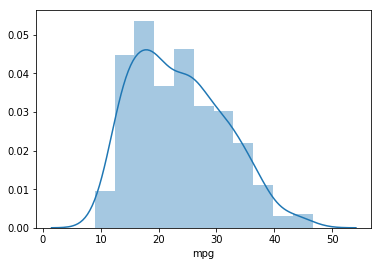

In [114]:
sns.distplot(df_inputed['mpg'],bins=11)

In [115]:
df_inputed.skew(axis=0)

acceleration    0.278777
cylinders       0.526922
displacement    0.719645
horsepower      1.100098
model year      0.011535
mpg             0.457066
origin          0.923776
weight          0.531063
dtype: float64

In [124]:
features = df_inputed.columns.difference(['mpg'])
correlations = df_inputed[features].corr().abs().unstack().sort_values().reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head()

,level_0,level_1,0
0,origin,model year,0.180662
1,model year,origin,0.180662
2,acceleration,origin,0.205873
3,origin,acceleration,0.205873
4,model year,acceleration,0.288137


In [125]:
un_va = []
for feat in features:
    df_inputed[feat].value_counts()
    values = df_inputed[feat].value_counts()
    un_va.append([feat, values.max(), values.idxmax()])
un_va

[['acceleration', 23, 14.5],
 ['cylinders', 204, 4],
 ['displacement', 21, 97.0],
 ['horsepower', 22, 150.0],
 ['model year', 40, 73],
 ['origin', 249, 1],
 ['weight', 4, 1985]]

(array([1, 2, 3]), <a list of 3 Text xticklabel objects>)

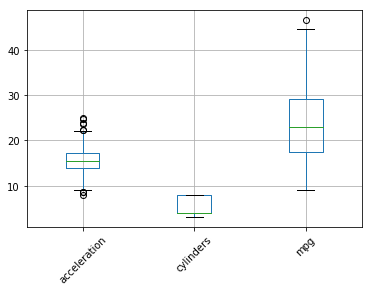

In [119]:
df_inputed[['acceleration','cylinders','mpg']].boxplot()
plt.xticks(rotation='45')

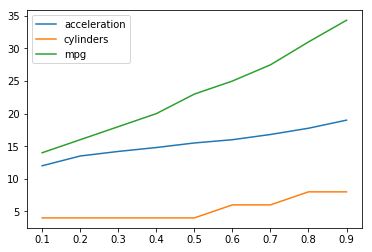

In [120]:
#checking 
df_inputed[['acceleration','cylinders','mpg']].quantile(np.arange(0.1,1.0,0.1)).plot.line()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024C873D5CC0>,
      dtype=object)

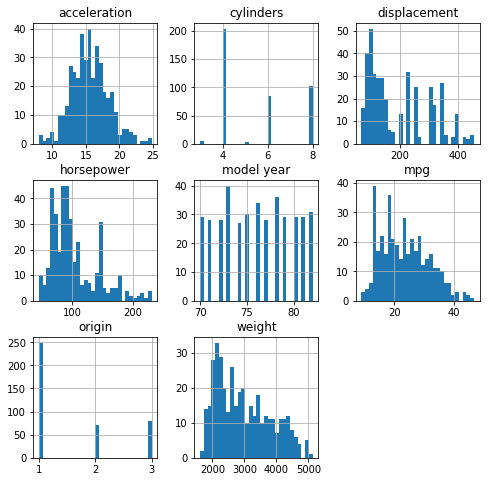

In [128]:
df_inputed.hist(bins=30,figsize=(8,8)) #checking distribution

In [122]:
pd.crosstab(df_inputed['displacement']>100,df_inputed['mpg']>20) #check proportions of cars with various values of two variables

mpg,False,True
displacement,,
False,3,95
True,157,143


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024C8C34C780>,
      dtype=object)

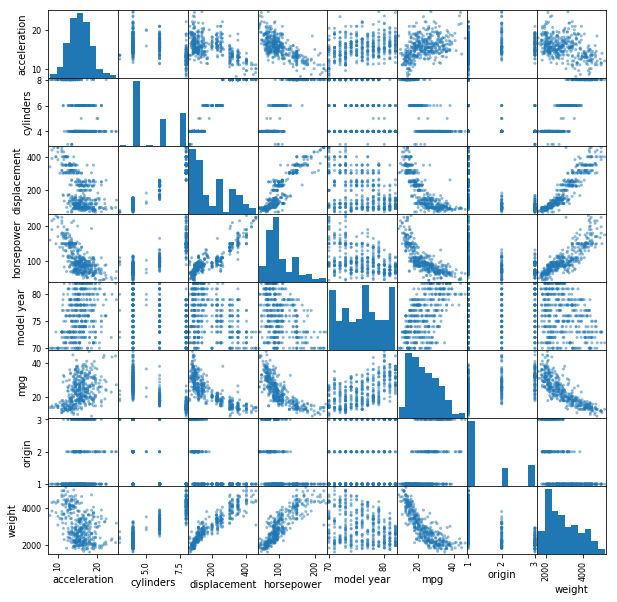

In [123]:
pd.scatter_matrix(df_inputed,figsize=(10,10))